In [1]:
# Section 1: Setup and Data Loading
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
import sys
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sys.path.append('../src/data')
sys.path.append('../src/analysis')
from data_loader import load_and_prepare_data, regions # type: ignore
from metrics import calculate_metrics # type: ignore

# Reference to previous notebook
print("This analysis builds on the data loaded in '01_data_loading.ipynb'")
print("Analyzing healthcare spending patterns across US states for 1991")

This analysis builds on the data loaded in '01_data_loading.ipynb'
Analyzing healthcare spending patterns across US states for 1991


In [2]:
# Section 2: Load and Prepare Data
# Load and prepare the healthcare spending data for analysis
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island',
                 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'],
    'Midwest': ['Ohio', 'Indiana', 'Illinois', 'Michigan', 'Wisconsin', 'Minnesota',
                'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
    'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia',
              'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky',
              'Tennessee', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah',
             'Nevada', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']
}

# In case you did not view the previous notebook, here is a brief overview of the data:
df, state_data, us_average, regions = load_and_prepare_data(file_path='../data/raw/kff_healthcare_spending_per_capita_1991.csv')

# # Display basic information about the dataset
print("\nDataset Overview:")
print("-----------------")
print(f"Total number of records: {state_data.shape[0]}")
print(f"Number of features: {state_data.shape[1]}")

# Column information
print("\nColumn Details:")
print("--------------")
for column in state_data.columns:
    print(f"Column: {column}")
    print(f"Data type: {state_data[column].dtype}")
    print(f"Missing values: {state_data[column].isnull().sum()}")
    print()

# Quick summary statistics
print("\nQuick Summary:")
print("-------------")
print(state_data.describe().round(2))

# Display first few rows of the cleaned data
print("\nSample of Cleaned Data:")
print("--------------------")
display(state_data.head())

# Verify regions are correctly assigned
print("\nStates per Region:")
print("----------------")
print(state_data['Region'].value_counts())

2659.0
<class 'numpy.float64'>

Dataset Overview:
-----------------
Total number of records: 51
Number of features: 3

Column Details:
--------------
Column: Location
Data type: object
Missing values: 0

Column: Health Spending per Capita
Data type: float64
Missing values: 0

Column: Region
Data type: object
Missing values: 0


Quick Summary:
-------------
       Health Spending per Capita
count                       51.00
mean                      2588.96
std                        407.90
min                       1966.00
25%                       2351.50
50%                       2530.00
75%                       2673.00
max                       4642.00

Sample of Cleaned Data:
--------------------


,Location,Health Spending per Capita,Region
1,Alabama,2523.0,South
2,Alaska,2553.0,West
3,Arizona,2434.0,West
4,Arkansas,2351.0,South
5,California,2659.0,West



States per Region:
----------------
Region
South        17
West         13
Midwest      12
Northeast     9
Name: count, dtype: int64



=== Basic Statistical Analysis ===

National Statistics:
------------------
US Average Spending: $2,659.00
Mean: $2,588.96
Median: $2,530.00
Standard Deviation: $407.90
Coefficient of Variation: 15.8%

Distribution Statistics:
----------------------
Skewness: 2.783
Kurtosis: 12.170

Percentile Analysis:
------------------
10th percentile: $2,249.00
25th percentile: $2,351.50
50th percentile: $2,530.00
75th percentile: $2,673.00
90th percentile: $2,944.00

Top 5 States by Healthcare Spending:
--------------------------------


,Location,Region,Health Spending per Capita
0,District of Columbia,South,4642.0
1,Massachusetts,Northeast,3313.0
2,Connecticut,Northeast,3305.0
3,New York,Northeast,3193.0
4,Pennsylvania,Northeast,3008.0



Bottom 5 States by Healthcare Spending:
-----------------------------------


,Location,Region,Health Spending per Capita
0,Utah,West,1966.0
1,Idaho,West,2113.0
2,Mississippi,South,2163.0
3,Wyoming,West,2216.0
4,New Mexico,West,2228.0



Basic Regional Metrics:
--------------------


Health Spending per Capita                                \
                                Mean     Std     Min     Max Count   
Region                                                               
Midwest                      2578.58  113.00  2352.0  2719.0    12   
Northeast                    2888.22  371.03  2328.0  3313.0     9   
South                        2609.65  566.25  2163.0  4642.0    17   
West                         2364.31  199.22  1966.0  2659.0    13   

                         
          Pct Above Avg  
Region                   
Midwest       33.333333  
Northeast     66.666667  
South         23.529412  
West           0.000000

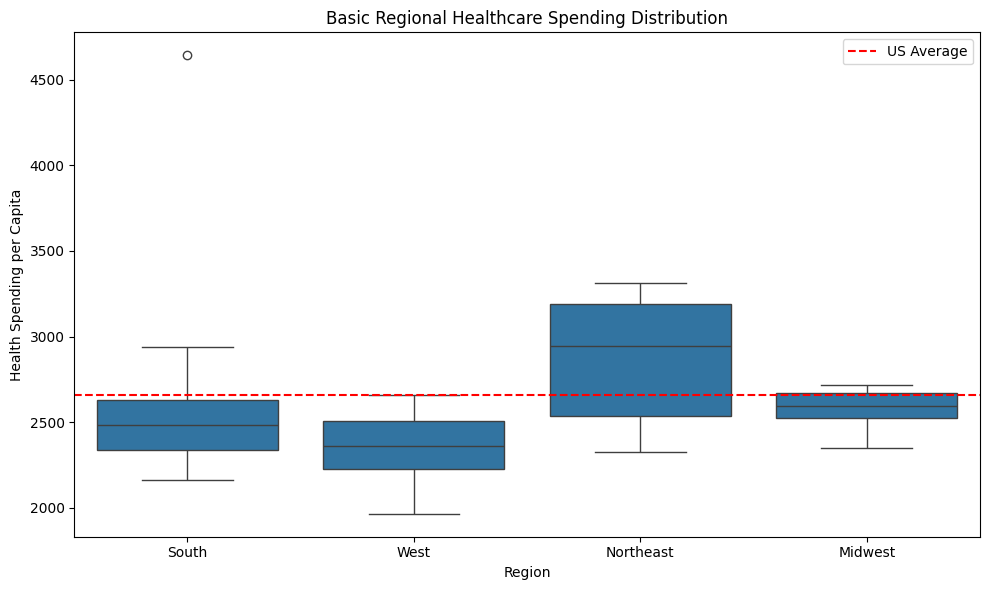

In [3]:
# Section 3: Basic Statistical Analysis
print("\n=== Basic Statistical Analysis ===")

# 3.1 National Statistics
print("\nNational Statistics:")
print("------------------")
print(f"US Average Spending: ${us_average:,.2f}")
print(f"Mean: ${state_data['Health Spending per Capita'].mean():,.2f}")
print(f"Median: ${state_data['Health Spending per Capita'].median():,.2f}")
print(f"Standard Deviation: ${state_data['Health Spending per Capita'].std():,.2f}")
print(f"Coefficient of Variation: {(state_data['Health Spending per Capita'].std() / state_data['Health Spending per Capita'].mean() * 100):.1f}%")

# Distribution Statistics
print("\nDistribution Statistics:")
print("----------------------")
print(f"Skewness: {state_data['Health Spending per Capita'].skew():.3f}")
print(f"Kurtosis: {state_data['Health Spending per Capita'].kurtosis():.3f}")

# Percentile Analysis
print("\nPercentile Analysis:")
print("------------------")
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    value = state_data['Health Spending per Capita'].quantile(p/100)
    print(f"{p}th percentile: ${value:,.2f}")

# 3.2 Top/Bottom States Analysis
print("\nTop 5 States by Healthcare Spending:")
print("--------------------------------")
display(state_data.nlargest(5, 'Health Spending per Capita')[['Location', 'Region', 'Health Spending per Capita']].reset_index(drop=True))

print("\nBottom 5 States by Healthcare Spending:")
print("-----------------------------------")
display(state_data.nsmallest(5, 'Health Spending per Capita')[['Location', 'Region', 'Health Spending per Capita']].reset_index(drop=True))

# 3.3 Basic Regional Metrics
print("\nBasic Regional Metrics:")
print("--------------------")
regional_metrics = state_data.groupby('Region').agg({
    'Health Spending per Capita': [
        ('Mean', 'mean'),
        ('Std', 'std'),
        ('Min', 'min'),
        ('Max', 'max'),
        ('Count', 'count')
    ]
}).round(2)

# Calculate percentage above national average for each region
for region in state_data['Region'].unique():
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    pct_above = (region_data > us_average).mean() * 100
    regional_metrics.loc[region, ('Health Spending per Capita', 'Pct Above Avg')] = pct_above

display(regional_metrics)

# Basic visualization of regional distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=state_data, x='Region', y='Health Spending per Capita')
plt.axhline(y=us_average, color='r', linestyle='--', label='US Average')
plt.title('Basic Regional Healthcare Spending Distribution')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


=== Regional Analysis ===

Comprehensive Regional Statistics:
-------------------------------


,Mean,Variance,States,Pct Above Avg
Region,,,,
Midwest,2578.58,12768.63,12,33.333333
Northeast,2888.22,137664.44,9,66.666667
South,2609.65,320640.62,17,23.529412
West,2364.31,39687.23,13,0.000000



Regional Comparisons to National Average:
-------------------------------------

Northeast Region:
Mean spending: $2,888.22
8.6% above national average
Number of states: 9

Midwest Region:
Mean spending: $2,578.58
3.0% below national average
Number of states: 12

South Region:
Mean spending: $2,609.65
1.9% below national average
Number of states: 17

West Region:
Mean spending: $2,364.31
11.1% below national average
Number of states: 13


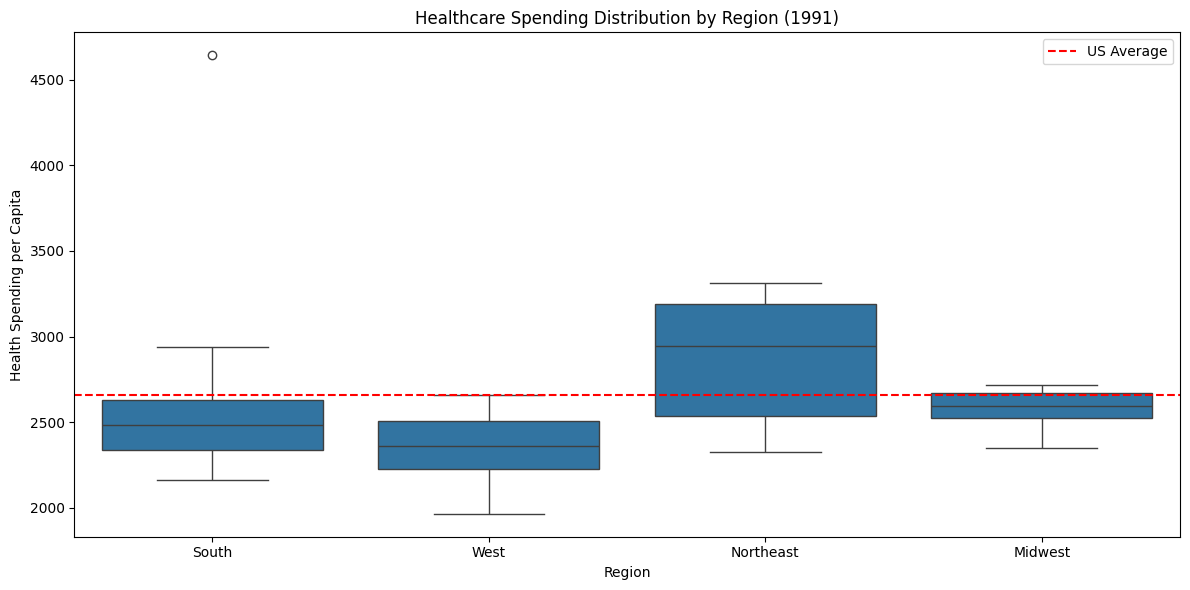

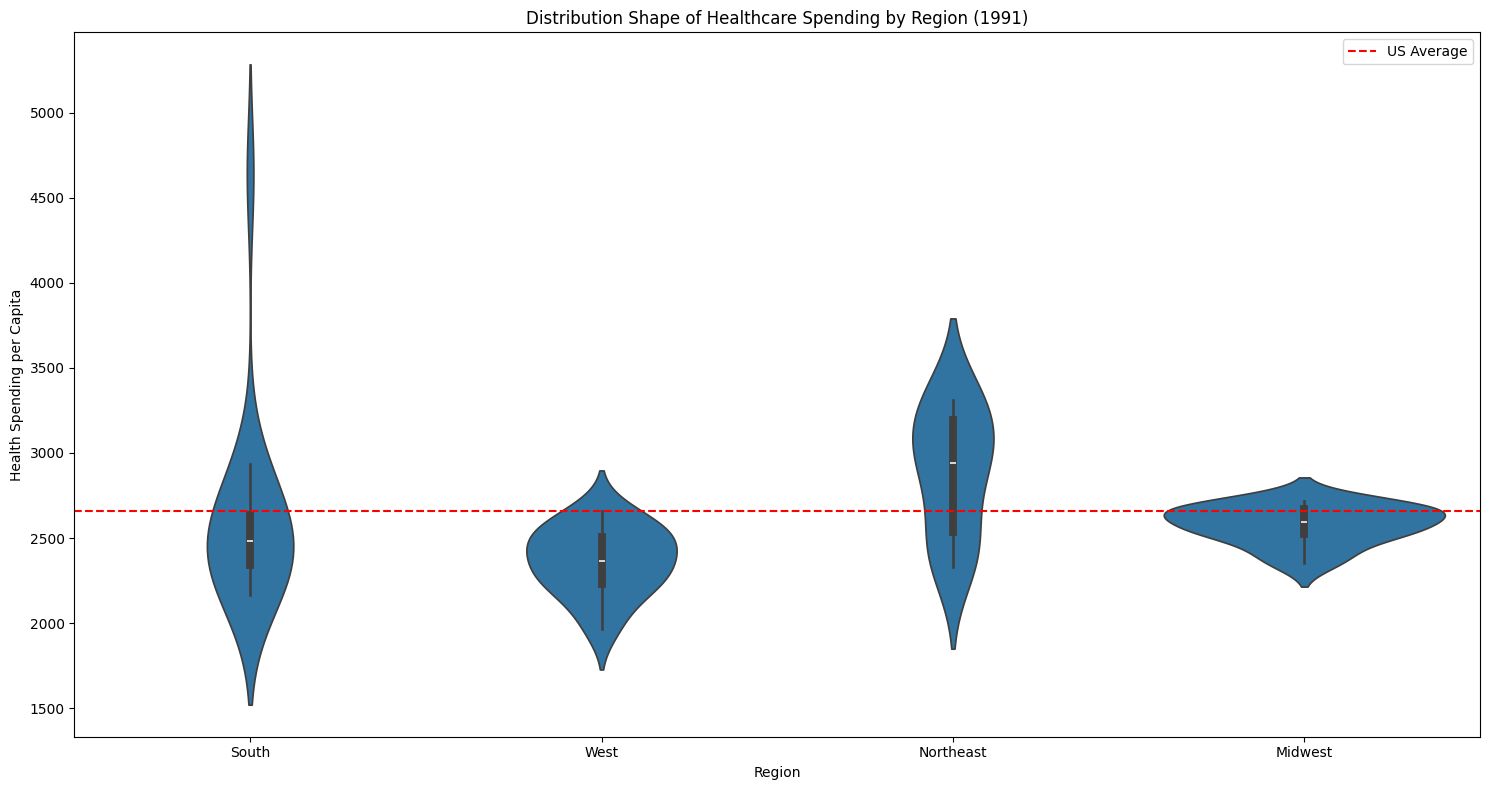


Regional Variance Analysis:
------------------------

Northeast Region:
Variance: $137,664.44
Standard Deviation: $371.03
Coefficient of Variation: 12.8%

Midwest Region:
Variance: $12,768.63
Standard Deviation: $113.00
Coefficient of Variation: 4.4%

South Region:
Variance: $320,640.62
Standard Deviation: $566.25
Coefficient of Variation: 21.7%

West Region:
Variance: $39,687.23
Standard Deviation: $199.22
Coefficient of Variation: 8.4%

Detailed State-by-State Analysis by Region:
---------------------------------------

Northeast Region Analysis:
--------------------------------------------------
Number of States: 9
Mean Spending: $2,888.22
Median Spending: $2,944.00
Standard Deviation: $371.03
Range: $985.00
Skewness: -0.404

States in region (ordered by spending):
Massachusetts: $3,313.00
Connecticut: $3,305.00
New York: $3,193.00
Pennsylvania: $3,008.00
New Jersey: $2,944.00
Rhode Island: $2,923.00
Maine: $2,538.00
New Hampshire: $2,442.00
Vermont: $2,328.00

States above nationa

In [4]:
# Section 4: Regional Analysis
print("\n=== Regional Analysis ===")

# 4.1 Comprehensive Regional Statistics
print("\nComprehensive Regional Statistics:")
print("-------------------------------")
region_overview = state_data.groupby('Region').agg({
    'Health Spending per Capita': [
        ('Mean', 'mean'),
        ('Variance', 'var'),
        ('States', 'size')
    ]
}).round(2)

# Add percentage above/below national average
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    pct_above = (region_data > us_average).mean() * 100
    region_overview.loc[region, ('Health Spending per Capita', 'Pct Above Avg')] = pct_above

region_overview.columns = region_overview.columns.droplevel(0)
display(region_overview)

# 4.2 Regional Comparisons to National Average
print("\nRegional Comparisons to National Average:")
print("-------------------------------------")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    mean_spending = region_data.mean()
    diff_from_natl = ((mean_spending - us_average) / us_average * 100)
    print(f"\n{region} Region:")
    print(f"Mean spending: ${mean_spending:,.2f}")
    print(f"{abs(diff_from_natl):.1f}% {'above' if diff_from_natl > 0 else 'below'} national average")
    print(f"Number of states: {len(region_data)}")

# 4.3 Box Plot Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=state_data, x='Region', y='Health Spending per Capita')
plt.axhline(y=us_average, color='r', linestyle='--', label='US Average')
plt.title('Healthcare Spending Distribution by Region (1991)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# 4.4 Violin Plot Analysis
plt.figure(figsize=(15, 8))
sns.violinplot(data=state_data, x='Region', y='Health Spending per Capita')
plt.axhline(y=us_average, color='r', linestyle='--', label='US Average')
plt.title('Distribution Shape of Healthcare Spending by Region (1991)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# 4.5 Regional Variance Analysis
print("\nRegional Variance Analysis:")
print("------------------------")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    print(f"\n{region} Region:")
    print(f"Variance: ${region_data.var():,.2f}")
    print(f"Standard Deviation: ${region_data.std():,.2f}")
    print(f"Coefficient of Variation: {(region_data.std() / region_data.mean() * 100):.1f}%")

# 4.6 Detailed State-by-State Breakdown
print("\nDetailed State-by-State Analysis by Region:")
print("---------------------------------------")
for region in ['Northeast', 'Midwest', 'South', 'West']:
   region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
   
   print(f"\n{region} Region Analysis:")
   print("-" * 50)
   print(f"Number of States: {len(region_data)}")
   print(f"Mean Spending: ${region_data.mean():,.2f}")
   print(f"Median Spending: ${region_data.median():,.2f}")
   print(f"Standard Deviation: ${region_data.std():,.2f}")
   print(f"Range: ${region_data.max() - region_data.min():,.2f}")
   print(f"Skewness: {region_data.skew():,.3f}")  # Measure of distribution asymmetry
   
   # List states in this region with their spending
   print("\nStates in region (ordered by spending):")
   region_states = state_data[state_data['Region'] == region].sort_values('Health Spending per Capita', ascending=False)
   for _, row in region_states.iterrows():
      print(f"{row['Location']}: ${row['Health Spending per Capita']:,.2f}")

   # Calculate what percentage of states are above/below national average
   above_avg = sum(region_data > us_average)
   total_states = len(region_data)
   print(f"\nStates above national average: {above_avg} ({(above_avg/total_states*100):.1f}%)")


=== Distribution Analysis ===


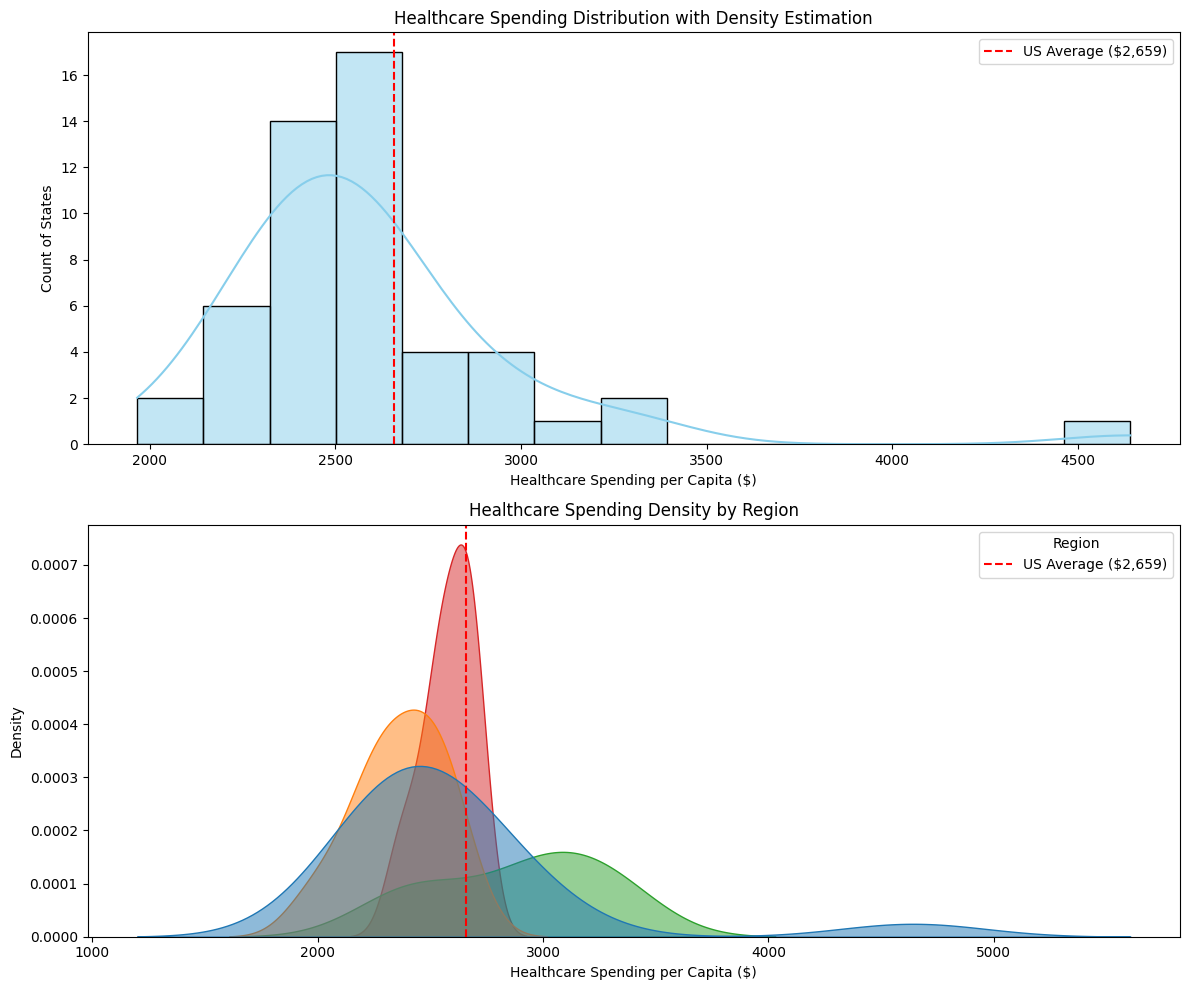


Distribution Statistics:
Mean: $2,588.96
Median: $2,530.00
Standard Deviation: $407.90
Skewness: 2.783
Kurtosis: 12.170

Normality Test p-value: 0.0000
Distribution is non-normal at 5% significance level

Outlier Analysis:

Potential Outliers (beyond 1.5 IQR):
Connecticut: $3,305.00
District of Columbia: $4,642.00
Massachusetts: $3,313.00
New York: $3,193.00

Percentile Analysis:
10th percentile: $2,249.00
25th percentile: $2,351.50
50th percentile: $2,530.00
75th percentile: $2,673.00
90th percentile: $2,944.00

Regional Distribution Comparison:

Northeast Region:
Mean: $2,888.22
Median: $2,944.00
Std Dev: $371.03
Skewness: -0.404
Kurtosis: -1.395

Midwest Region:
Mean: $2,578.58
Median: $2,593.00
Std Dev: $113.00
Skewness: -0.761
Kurtosis: -0.155

South Region:
Mean: $2,609.65
Median: $2,484.00
Std Dev: $566.25
Skewness: 3.188
Kurtosis: 11.553

West Region:
Mean: $2,364.31
Median: $2,364.00
Std Dev: $199.22
Skewness: -0.472
Kurtosis: -0.281


In [5]:
# Section 5: Distribution Analysis
print("\n=== Distribution Analysis ===")

regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 
                 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 
              'Virginia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 
              'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming',
             'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

# 5.1 Overall Distribution Visualization
# Create figure with two subplots for distribution analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histogram with KDE
sns.histplot(
   data=state_data,
   x='Health Spending per Capita',
   kde=True,
   ax=ax1,
   bins=15,
   color='skyblue'
)
ax1.axvline(x=us_average, color='red', linestyle='--', label=f'US Average (${us_average:,.0f})')
ax1.set_title('Healthcare Spending Distribution with Density Estimation')
ax1.set_xlabel('Healthcare Spending per Capita ($)')
ax1.set_ylabel('Count of States')
ax1.legend()

# Regional KDE comparison
sns.kdeplot(
   data=state_data,
   x='Health Spending per Capita',
   hue='Region',
   ax=ax2,
   fill=True,
   alpha=0.5
)
ax2.axvline(x=us_average, color='red', linestyle='--', label=f'US Average (${us_average:,.0f})')
ax2.set_title('Healthcare Spending Density by Region')
ax2.set_xlabel('Healthcare Spending per Capita ($)')
ax2.set_ylabel('Density')
ax2.legend(title='Region')

plt.tight_layout()
plt.show()

# 5.2 Distribution Statistics and Normality Testing
print("\nDistribution Statistics:")
print("=====================")
print(f"Mean: ${state_data['Health Spending per Capita'].mean():,.2f}")
print(f"Median: ${state_data['Health Spending per Capita'].median():,.2f}")
print(f"Standard Deviation: ${state_data['Health Spending per Capita'].std():,.2f}")
print(f"Skewness: {state_data['Health Spending per Capita'].skew():.3f}")
print(f"Kurtosis: {state_data['Health Spending per Capita'].kurtosis():.3f}")

# Normality Test
_, p_value = stats.normaltest(state_data['Health Spending per Capita'])
print(f"\nNormality Test p-value: {p_value:.4f}")
print("Distribution is", "normal" if p_value > 0.05 else "non-normal", "at 5% significance level")

# 5.3 Outlier Detection
print("\nOutlier Analysis:")
print("===============")
Q1 = state_data['Health Spending per Capita'].quantile(0.25)
Q3 = state_data['Health Spending per Capita'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = state_data[
   (state_data['Health Spending per Capita'] < lower_bound) |
   (state_data['Health Spending per Capita'] > upper_bound)
]

print("\nPotential Outliers (beyond 1.5 IQR):")
for _, row in outliers.iterrows():
   print(f"{row['Location']}: ${row['Health Spending per Capita']:,.2f}")

# 5.4 Percentile Analysis
print("\nPercentile Analysis:")
print("==================")
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
   value = state_data['Health Spending per Capita'].quantile(p/100)
   print(f"{p}th percentile: ${value:,.2f}")

# 5.5 Regional Distribution Comparison
print("\nRegional Distribution Comparison:")
print("==============================")
for region in regions.keys():
   region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
   print(f"\n{region} Region:")
   print(f"Mean: ${region_data.mean():,.2f}")
   print(f"Median: ${region_data.median():,.2f}")
   print(f"Std Dev: ${region_data.std():,.2f}")
   print(f"Skewness: {region_data.skew():.3f}")
   print(f"Kurtosis: {region_data.kurtosis():.3f}")


=== Comparative Analysis ===


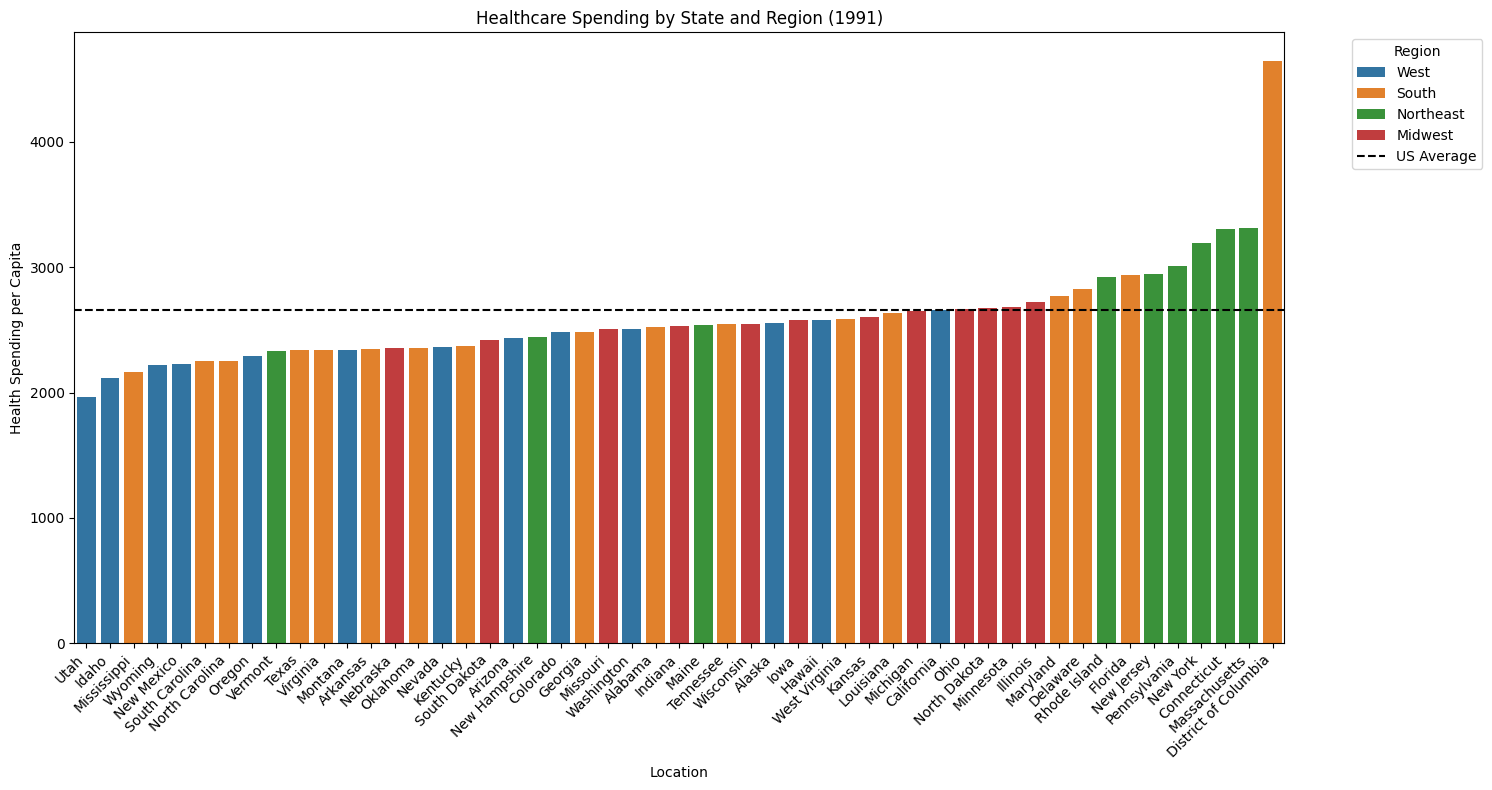


States Relative to US Average:
States Above Average: 14
States Below Average: 36

Most Extreme Differences from US Average:

Highest above average:


,Location,Region,Percent_Difference
0,District of Columbia,South,74.6
1,Massachusetts,Northeast,24.6
2,Connecticut,Northeast,24.3



Lowest below average:


,Location,Region,Percent_Difference
0,Utah,West,-26.1
1,Idaho,West,-20.5
2,Mississippi,South,-18.7


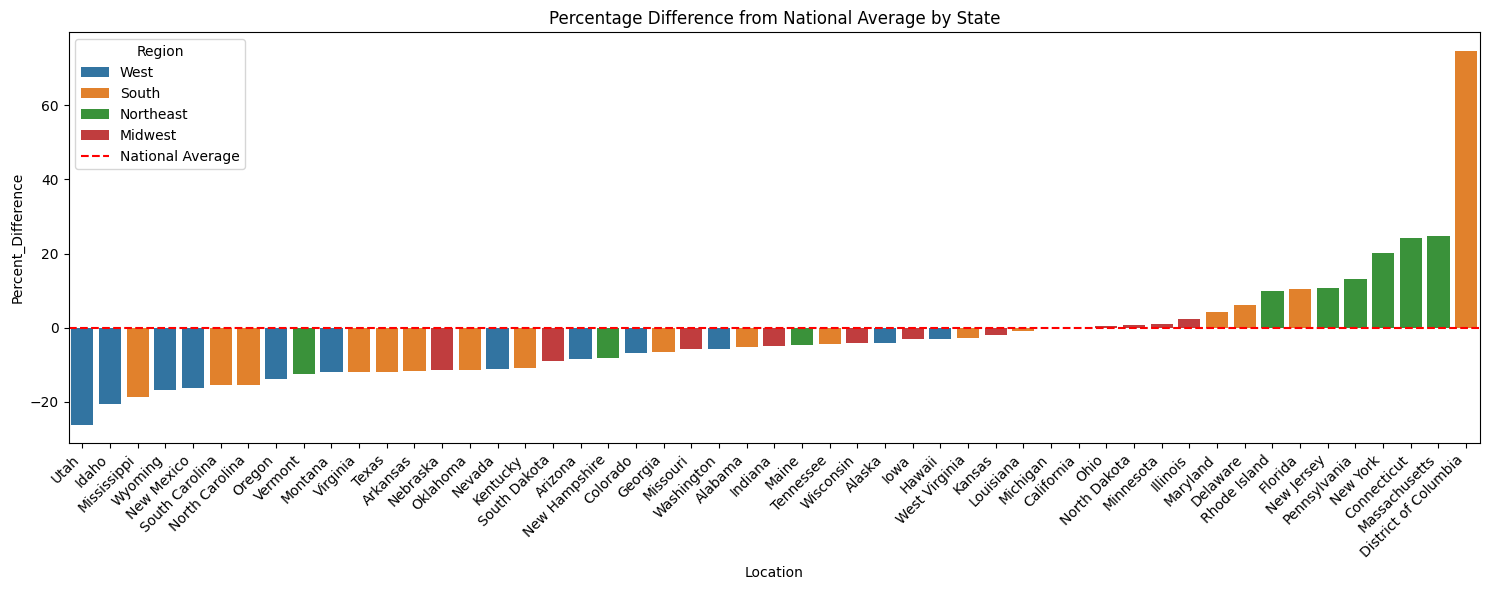


Neighbor Analysis:

New York:
State Spending: $3,193.00
Average Neighbor Spending: $2,979.60
Difference from Neighbors: 7.2%

California:
State Spending: $2,659.00
Average Neighbor Spending: $2,363.67
Difference from Neighbors: 12.5%

Texas:
State Spending: $2,339.00
Average Neighbor Spending: $2,391.75
Difference from Neighbors: -2.2%

Florida:
State Spending: $2,937.00
Average Neighbor Spending: $2,503.50
Difference from Neighbors: 17.3%

Illinois:
State Spending: $2,719.00
Average Neighbor Spending: $2,507.00
Difference from Neighbors: 8.5%

Regional Patterns and Trends:

Northeast Region Patterns:
------------------------------
Average spending: $2,888.22
Spending range: $985.00
States above national average: 6/9
Percentage of states above average: 66.7%
Regional variance: $137,664.44

Midwest Region Patterns:
------------------------------
Average spending: $2,578.58
Spending range: $367.00
States above national average: 4/12
Percentage of states above average: 33.3%
Regional var

In [6]:
# Section 6: Comparative Analysis
print("\n=== Comparative Analysis ===")

# 6.1 State Rankings Visualization
plt.figure(figsize=(15, 8))
sns.barplot(data=state_data.sort_values('Health Spending per Capita', ascending=True),
           x='Location',
           y='Health Spending per Capita',
           hue='Region',
           legend=True)
plt.axhline(y=us_average, color='black', linestyle='--', label='US Average')
plt.xticks(rotation=45, ha='right')
plt.title('Healthcare Spending by State and Region (1991)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6.2 Distance from National Average Analysis
# Calculate raw and percentage differences
state_data['Difference_from_US_Avg'] = state_data['Health Spending per Capita'] - us_average
state_data['Percent_Difference'] = (state_data['Difference_from_US_Avg'] / us_average * 100).round(1)

print("\nStates Relative to US Average:")
print(f"States Above Average: {sum(state_data['Health Spending per Capita'] > us_average)}")
print(f"States Below Average: {sum(state_data['Health Spending per Capita'] < us_average)}")

print("\nMost Extreme Differences from US Average:")
print("\nHighest above average:")
display(state_data.nlargest(3, 'Percent_Difference')[['Location', 'Region', 'Percent_Difference']].reset_index(drop=True))

print("\nLowest below average:")
display(state_data.nsmallest(3, 'Percent_Difference')[['Location', 'Region', 'Percent_Difference']].reset_index(drop=True))

# 6.3 Percentage Difference Visualization
# Create categories for difference from average
state_data['Difference_Category'] = pd.cut(state_data['Percent_Difference'],
                                        bins=[-float('inf'), -20, -10, 0, 10, 20, float('inf')],
                                        labels=['Very Low', 'Low', 'Near Average (Lower)',
                                               'Near Average (Higher)', 'High', 'Very High'])

plt.figure(figsize=(15, 6))
sns.barplot(data=state_data.sort_values('Percent_Difference'),
           x='Location',
           y='Percent_Difference',
           hue='Region')
plt.axhline(y=0, color='r', linestyle='--', label='National Average')
plt.title('Percentage Difference from National Average by State')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

# 6.4 Neighbor Analysis
print("\nNeighbor Analysis:")
print("================")
# Define state neighbors
state_neighbors = {
   'New York': ['Connecticut', 'Massachusetts', 'Vermont', 'New Jersey', 'Pennsylvania'],
   'California': ['Oregon', 'Nevada', 'Arizona'],
   'Texas': ['New Mexico', 'Oklahoma', 'Arkansas', 'Louisiana'],
   'Florida': ['Georgia', 'Alabama'],
   'Illinois': ['Wisconsin', 'Indiana', 'Kentucky', 'Missouri', 'Iowa']
}

# Calculate differences with neighbors
for state, neighbors in state_neighbors.items():
   state_spending = state_data[state_data['Location'] == state]['Health Spending per Capita'].values[0]
   neighbor_spending = state_data[state_data['Location'].isin(neighbors)]['Health Spending per Capita'].mean()
   diff_from_neighbors = ((state_spending - neighbor_spending) / neighbor_spending * 100).round(1)
   print(f"\n{state}:")
   print(f"State Spending: ${state_spending:,.2f}")
   print(f"Average Neighbor Spending: ${neighbor_spending:,.2f}")
   print(f"Difference from Neighbors: {diff_from_neighbors}%")

# 6.5 Regional Patterns and Trends
print("\nRegional Patterns and Trends:")
print("==========================")
for region in ['Northeast', 'Midwest', 'South', 'West']:
   region_data = state_data[state_data['Region'] == region]
   
   print(f"\n{region} Region Patterns:")
   print("-" * 30)
   print(f"Average spending: ${region_data['Health Spending per Capita'].mean():,.2f}")
   print(f"Spending range: ${region_data['Health Spending per Capita'].max() - region_data['Health Spending per Capita'].min():,.2f}")
   print(f"States above national average: {sum(region_data['Health Spending per Capita'] > us_average)}/{len(region_data)}")
   
   # Calculate regional trend metrics
   above_avg_pct = (sum(region_data['Health Spending per Capita'] > us_average) / len(region_data) * 100)
   region_variance = region_data['Health Spending per Capita'].var()
   
   print(f"Percentage of states above average: {above_avg_pct:.1f}%")
   print(f"Regional variance: ${region_variance:,.2f}")


=== Advanced Statistical Analysis ===

ANOVA Results:
                sum_sq    df         F    PR(>F)
Region    1.470681e+06   3.0  3.364452  0.026286
Residual  6.848267e+06  47.0       NaN       NaN

Tukey's HSD Post-hoc Test Results:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower    upper   reject
--------------------------------------------------------------
  Midwest Northeast  309.6389 0.2681 -138.6664 757.9441  False
  Midwest     South   31.0637 0.9964 -352.2549 414.3824  False
  Midwest      West -214.2756 0.5043 -621.2657 192.7144  False
Northeast     South -278.5752 0.3002 -697.6745 140.5242  False
Northeast      West -523.9145  0.014 -964.7682 -83.0608   True
    South      West -245.3394 0.3128 -619.9159 129.2372  False
--------------------------------------------------------------


<Figure size 1000x600 with 0 Axes>

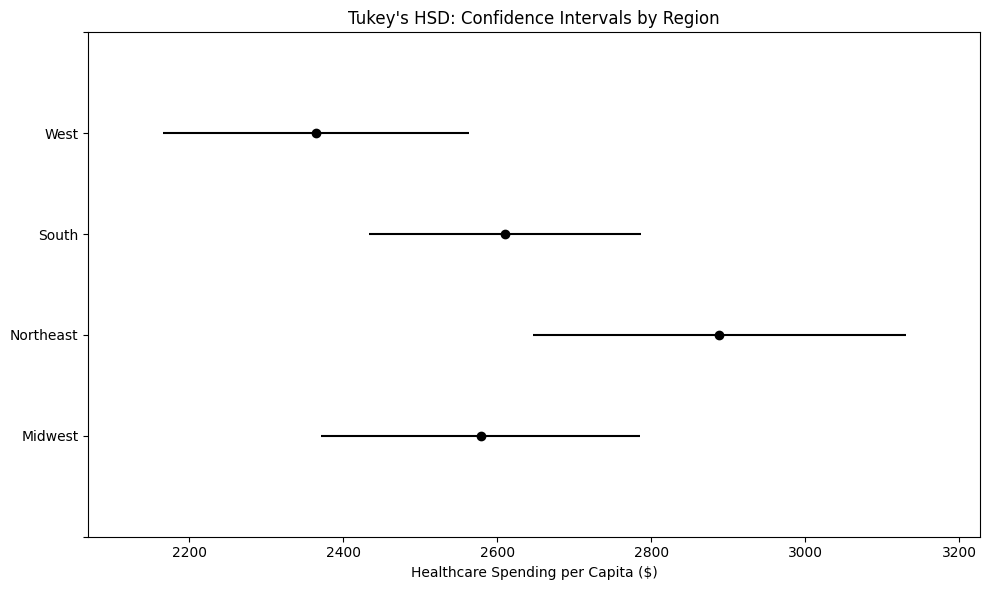


Variance Components Analysis:
Total Variance: $166,378.96
Between-Region Variance: $2,389,554.57
Within-Region Variance: $145,707.81
Percentage of variance explained by regional differences: 1436.2%

Statistical Significance Testing:

One-sample t-tests (comparing to national average):

Northeast Region:
T-statistic: 1.853
P-value: 0.1009
Conclusion: Not significantly different from national average

Midwest Region:
T-statistic: -2.465
P-value: 0.0314
Conclusion: Significantly different from national average

South Region:
T-statistic: -0.359
P-value: 0.7240
Conclusion: Not significantly different from national average

West Region:
T-statistic: -5.334
P-value: 0.0002
Conclusion: Significantly different from national average

Levene's Test for Homogeneity of Variances:
P-value: 0.2665
Conclusion: Variances are not significantly different

Effect Size Analysis:
Eta-squared: 0.017
Interpretation: Small effect


In [7]:
# Section 7: Advanced Statistical Analysis
print("\n=== Advanced Statistical Analysis ===")

# 7.1 ANOVA Testing
# Prepare data for ANOVA
anova_data = state_data[['Health Spending per Capita', 'Region']]
# Perform ANOVA
model = sm.formula.ols('Q("Health Spending per Capita") ~ Region', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Results:")
print("=============")
print(anova_table)

# 7.2 Tukey's HSD Post-hoc Analysis
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=anova_data['Health Spending per Capita'],
                         groups=anova_data['Region'],
                         alpha=0.05)
print("\nTukey's HSD Post-hoc Test Results:")
print("================================")
print(tukey)

# Visualize Tukey's HSD results
plt.figure(figsize=(10, 6))
tukey.plot_simultaneous()
plt.title("Tukey's HSD: Confidence Intervals by Region")
plt.xlabel('Healthcare Spending per Capita ($)')
plt.tight_layout()
plt.show()

# 7.3 Variance Components Analysis
print("\nVariance Components Analysis:")
print("==========================")
# Calculate overall variance metrics
total_variance = state_data['Health Spending per Capita'].var()
regional_means = state_data.groupby('Region')['Health Spending per Capita'].mean()
overall_mean = state_data['Health Spending per Capita'].mean()

# Between-region variance
between_region_var = sum([(mean - overall_mean) ** 2 for mean in regional_means]) * len(state_data) / (len(regional_means) - 1)

# Calculate within-region variance (corrected version)
within_region_vars = []
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    n = len(region_data)
    var = region_data.var()
    within_region_vars.append(var * (n - 1))

within_region_var = sum(within_region_vars) / (len(state_data) - len(regional_means))

print(f"Total Variance: ${total_variance:,.2f}")
print(f"Between-Region Variance: ${between_region_var:,.2f}")
print(f"Within-Region Variance: ${within_region_var:,.2f}")
print(f"Percentage of variance explained by regional differences: {(between_region_var/total_variance*100):.1f}%")

# 7.4 Statistical Significance Testing
print("\nStatistical Significance Testing:")
print("==============================")

# T-tests comparing each region to national average
print("\nOne-sample t-tests (comparing to national average):")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    t_stat, p_val = stats.ttest_1samp(region_data, us_average)
    print(f"\n{region} Region:")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_val:.4f}")
    print("Conclusion:", "Significantly different from national average" if p_val < 0.05 else "Not significantly different from national average")

# Levene's test for homogeneity of variances
_, levene_p = stats.levene(*[group['Health Spending per Capita'].values 
                            for name, group in state_data.groupby('Region')])
print("\nLevene's Test for Homogeneity of Variances:")
print(f"P-value: {levene_p:.4f}")
print("Conclusion:", "Variances are significantly different" if levene_p < 0.05 else "Variances are not significantly different")

# Effect size calculation (Eta-squared)
ss_between = sum((state_data.groupby('Region')['Health Spending per Capita'].mean() - 
                 state_data['Health Spending per Capita'].mean()) ** 2)
ss_total = sum((state_data['Health Spending per Capita'] - 
                state_data['Health Spending per Capita'].mean()) ** 2)
eta_squared = ss_between / ss_total

print("\nEffect Size Analysis:")
print(f"Eta-squared: {eta_squared:.3f}")
print("Interpretation:", 
      "Large effect" if eta_squared > 0.14 else
      "Medium effect" if eta_squared > 0.06 else
      "Small effect")


=== Visualization Suite ===


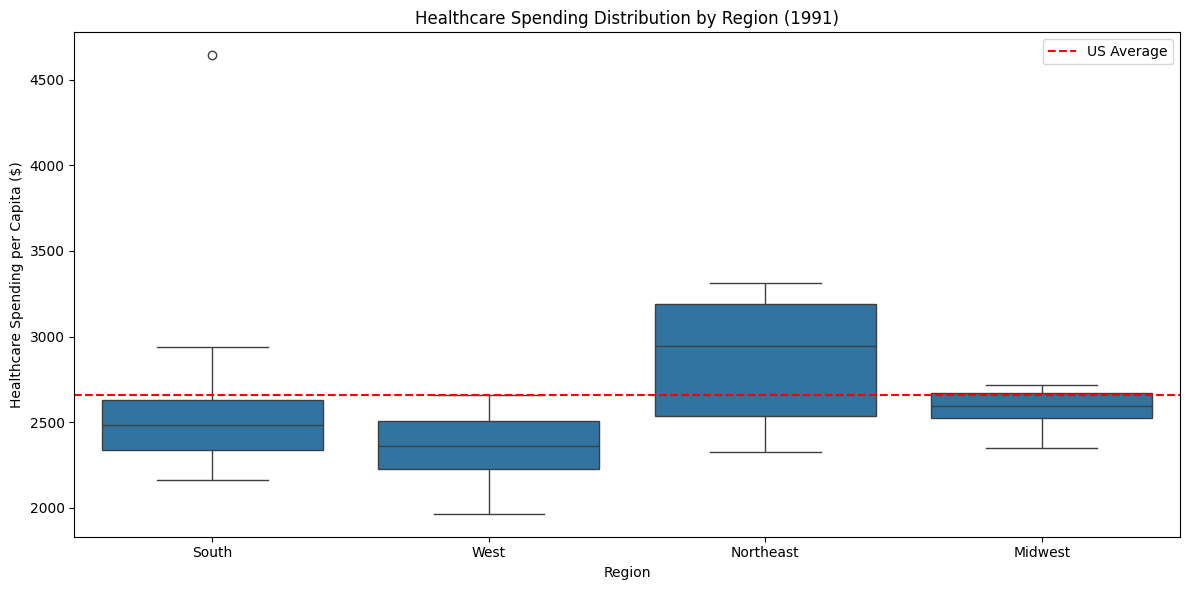

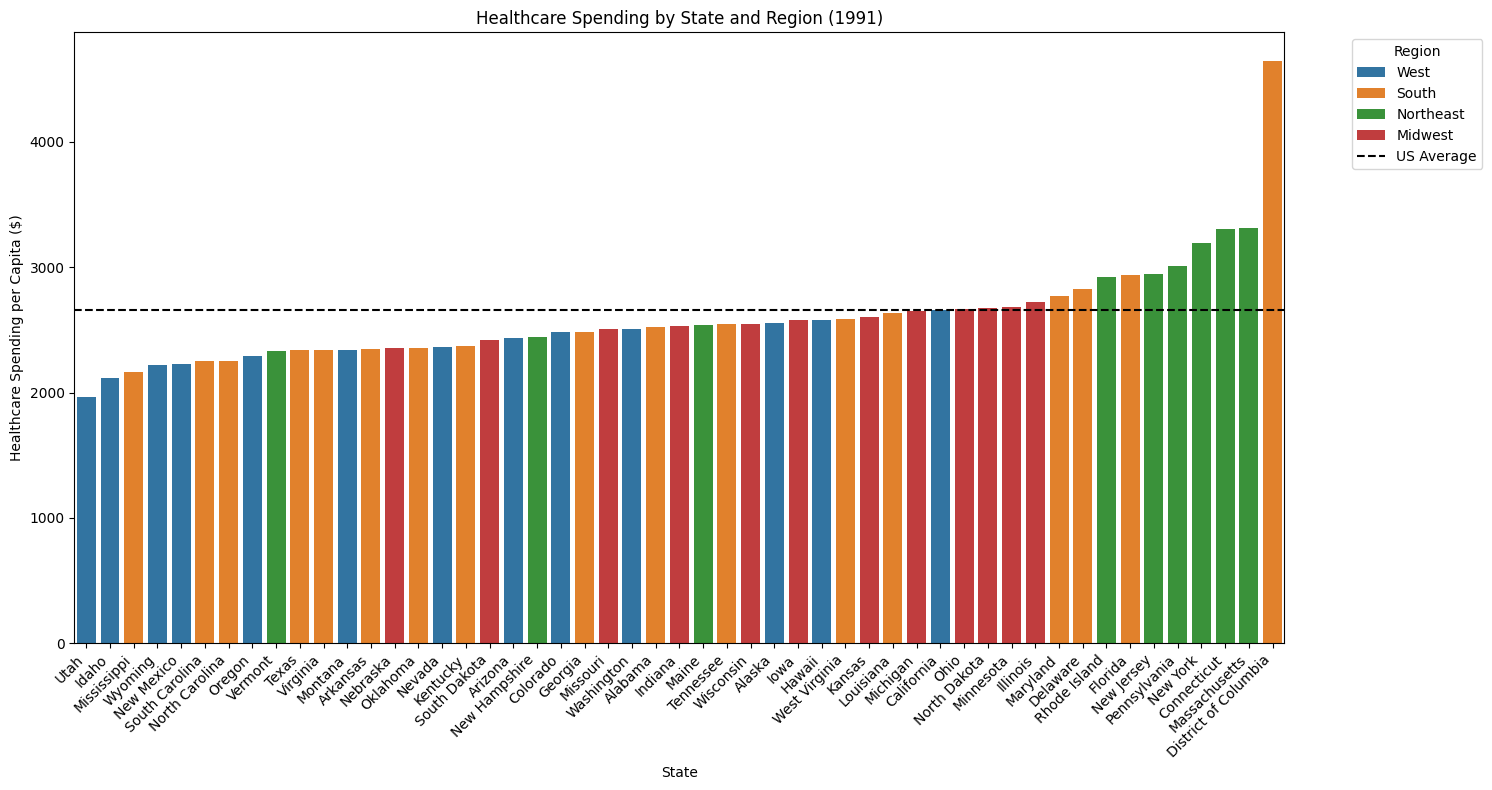

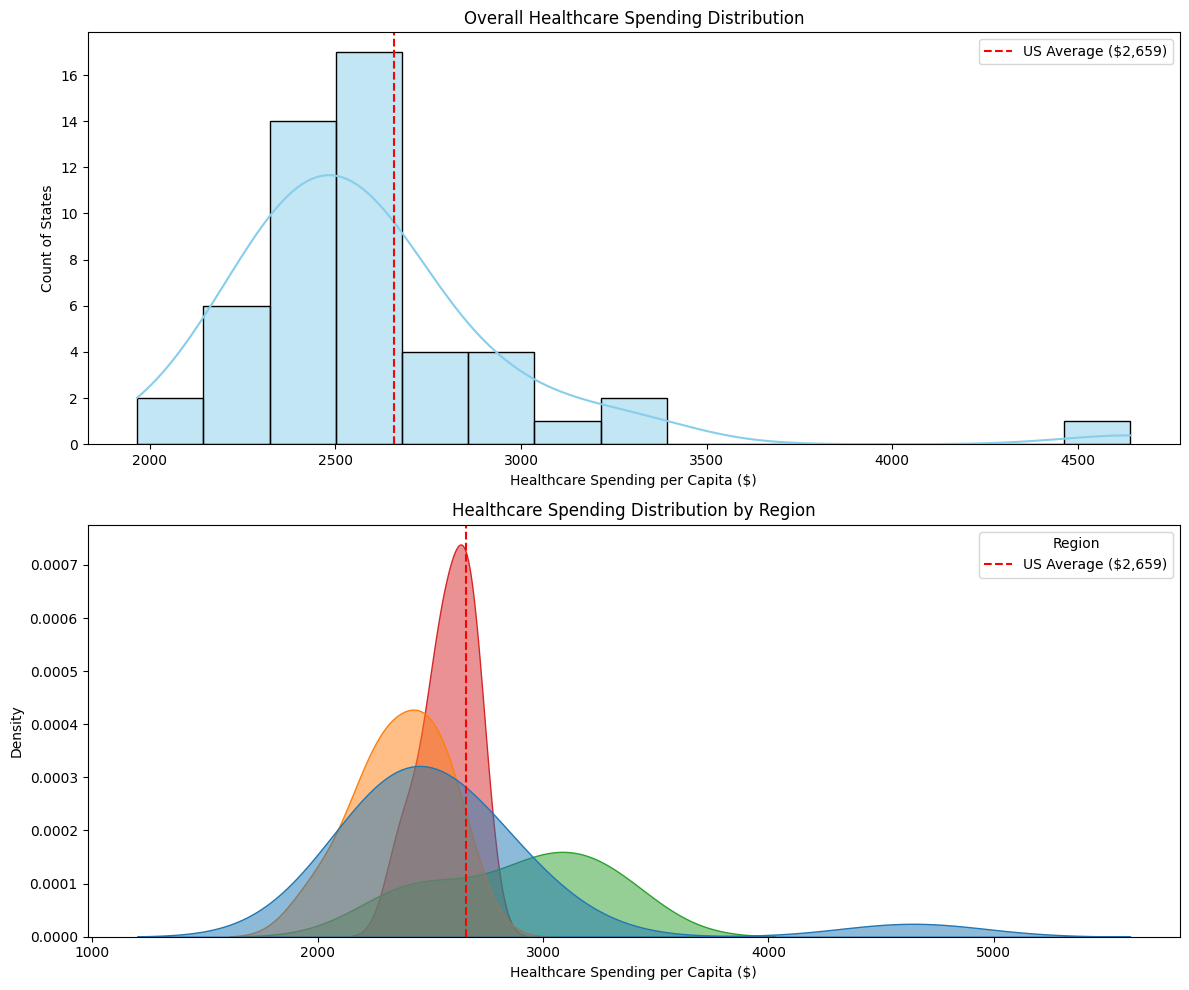

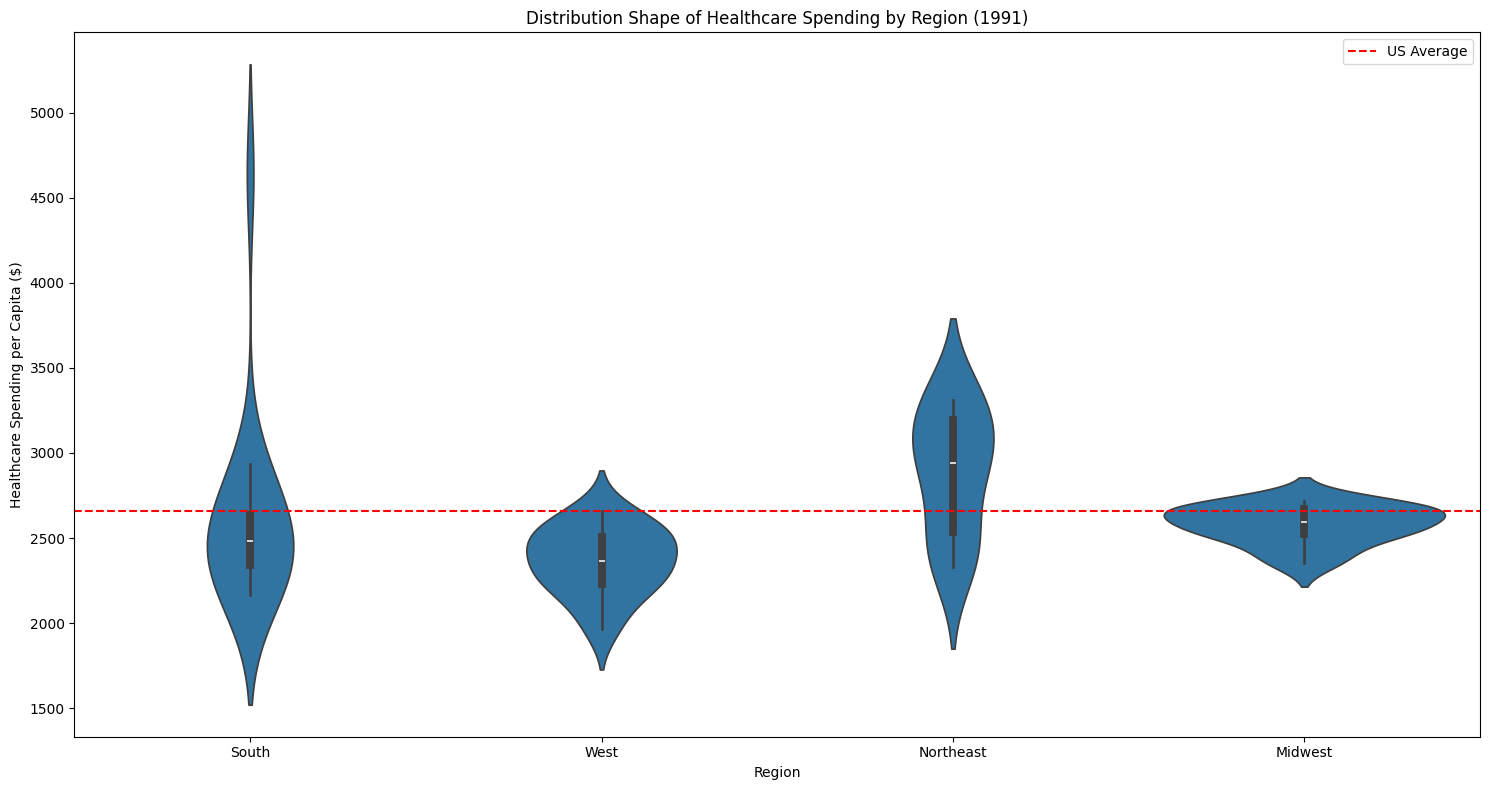

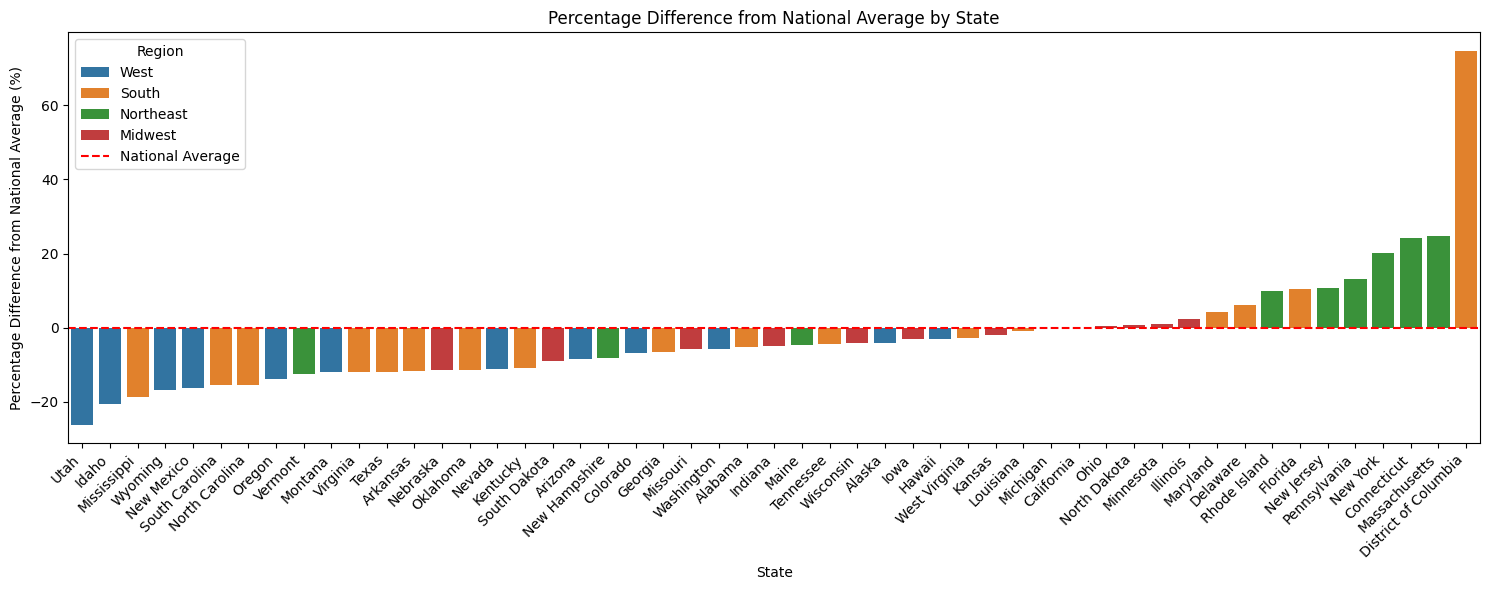

<Figure size 1000x600 with 0 Axes>

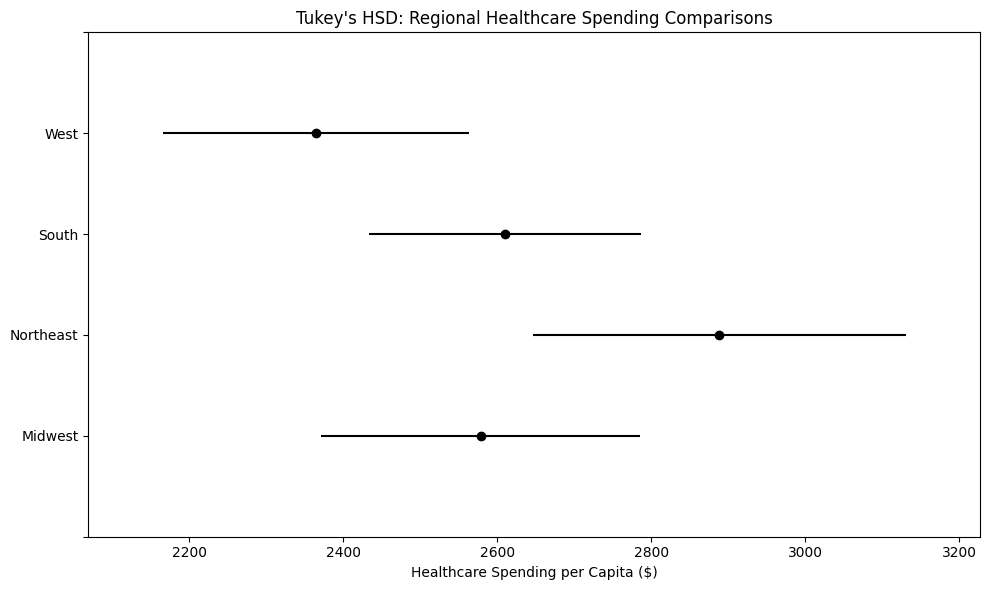

In [8]:
# Section 8: Visualization Suite
print("\n=== Visualization Suite ===")

# 8.1 Regional Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=state_data, x='Region', y='Health Spending per Capita')
plt.axhline(y=us_average, color='r', linestyle='--', label='US Average')
plt.title('Healthcare Spending Distribution by Region (1991)')
plt.xlabel('Region')
plt.ylabel('Healthcare Spending per Capita ($)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# 8.2 State Rankings Bar Chart
plt.figure(figsize=(15, 8))
sns.barplot(data=state_data.sort_values('Health Spending per Capita', ascending=True),
            x='Location',
            y='Health Spending per Capita',
            hue='Region',
            legend=True)
plt.axhline(y=us_average, color='black', linestyle='--', label='US Average')
plt.xticks(rotation=45, ha='right')
plt.title('Healthcare Spending by State and Region (1991)')
plt.xlabel('State')
plt.ylabel('Healthcare Spending per Capita ($)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 8.3 Distribution Histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Overall Distribution
sns.histplot(data=state_data,
             x='Health Spending per Capita',
             kde=True,
             ax=ax1,
             bins=15,
             color='skyblue')
ax1.axvline(x=us_average, color='red', linestyle='--', label=f'US Average (${us_average:,.0f})')
ax1.set_title('Overall Healthcare Spending Distribution')
ax1.set_xlabel('Healthcare Spending per Capita ($)')
ax1.set_ylabel('Count of States')
ax1.legend()

# Regional Distribution Comparison
sns.kdeplot(data=state_data,
            x='Health Spending per Capita',
            hue='Region',
            ax=ax2,
            fill=True,
            alpha=0.5)
ax2.axvline(x=us_average, color='red', linestyle='--', label=f'US Average (${us_average:,.0f})')
ax2.set_title('Healthcare Spending Distribution by Region')
ax2.set_xlabel('Healthcare Spending per Capita ($)')
ax2.set_ylabel('Density')
ax2.legend(title='Region')
plt.tight_layout()
plt.show()

# 8.4 Regional Violin Plots
plt.figure(figsize=(15, 8))
sns.violinplot(data=state_data, x='Region', y='Health Spending per Capita')
plt.axhline(y=us_average, color='r', linestyle='--', label='US Average')
plt.title('Distribution Shape of Healthcare Spending by Region (1991)')
plt.xlabel('Region')
plt.ylabel('Healthcare Spending per Capita ($)')
plt.legend()
plt.tight_layout()
plt.show()

# 8.5 Comparative Bar Charts (Percentage Difference from National Average)
plt.figure(figsize=(15, 6))
sns.barplot(data=state_data.sort_values('Percent_Difference'),
            x='Location',
            y='Percent_Difference',
            hue='Region')
plt.axhline(y=0, color='r', linestyle='--', label='National Average')
plt.title('Percentage Difference from National Average by State')
plt.xlabel('State')
plt.ylabel('Percentage Difference from National Average (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

# 8.6 Tukey's HSD Visualization
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=state_data['Health Spending per Capita'],
                         groups=state_data['Region'],
                         alpha=0.05)
plt.figure(figsize=(10, 6))
tukey.plot_simultaneous()
plt.title("Tukey's HSD: Regional Healthcare Spending Comparisons")
plt.xlabel('Healthcare Spending per Capita ($)')
plt.tight_layout()
plt.show()

In [9]:
# Section 9: Findings and Conclusions
print("\n=== Findings and Conclusions ===")

# 9.1 Key Takeaways
print("\nKey Takeaways:")
print("=============")
# Calculate overall statistics for summary
mean_spending = state_data['Health Spending per Capita'].mean()
median_spending = state_data['Health Spending per Capita'].median()
std_spending = state_data['Health Spending per Capita'].std()

print(f"1. Overall Healthcare Spending:")
print(f"   - National Average: ${us_average:,.2f}")
print(f"   - Mean State Spending: ${mean_spending:,.2f}")
print(f"   - Median State Spending: ${median_spending:,.2f}")
print(f"   - Standard Deviation: ${std_spending:,.2f}")

# High and low states
highest_state = state_data.loc[state_data['Health Spending per Capita'].idxmax()]
lowest_state = state_data.loc[state_data['Health Spending per Capita'].idxmin()]
print(f"\n2. Spending Range:")
print(f"   - Highest: {highest_state['Location']} (${highest_state['Health Spending per Capita']:,.2f})")
print(f"   - Lowest: {lowest_state['Location']} (${lowest_state['Health Spending per Capita']:,.2f})")
print(f"   - Range: ${highest_state['Health Spending per Capita'] - lowest_state['Health Spending per Capita']:,.2f}")

# 9.2 Regional Insights
print("\nRegional Insights:")
print("================")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]
    mean_regional = region_data['Health Spending per Capita'].mean()
    diff_from_natl = ((mean_regional - us_average) / us_average * 100)
    
    print(f"\n{region} Region:")
    print(f"- Average Spending: ${mean_regional:,.2f}")
    print(f"- {abs(diff_from_natl):.1f}% {'above' if diff_from_natl > 0 else 'below'} national average")
    print(f"- States above national average: {sum(region_data['Health Spending per Capita'] > us_average)}/{len(region_data)}")

# 9.3 Statistical Significance Summary
print("\nStatistical Significance Summary:")
print("==============================")
# ANOVA summary
model = sm.formula.ols('Q("Health Spending per Capita") ~ Region', data=state_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(f"ANOVA Results:")
print(f"- F-statistic: {anova_table['F'].iloc[0]:.3f}")
print(f"- p-value: {anova_table['PR(>F)'].iloc[0]:.4f}")

# Effect size
ss_between = sum((state_data.groupby('Region')['Health Spending per Capita'].mean() - 
                state_data['Health Spending per Capita'].mean()) ** 2)
ss_total = sum((state_data['Health Spending per Capita'] - 
               state_data['Health Spending per Capita'].mean()) ** 2)
eta_squared = ss_between / ss_total
print(f"\nEffect Size:")
print(f"- Eta-squared: {eta_squared:.3f}")

# 9.4 Hypothesis Testing Results
print("\nHypothesis Testing Results:")
print("=========================")
print("H0: No significant difference in healthcare spending across regions")
print("H1: Regional factors significantly influence healthcare spending")
print(f"\nConclusion: {('Reject H0' if anova_table['PR(>F)'].iloc[0] < 0.05 else 'Fail to reject H0')}")
print(f"Evidence suggests {'significant' if anova_table['PR(>F)'].iloc[0] < 0.05 else 'no significant'} differences between regions")

# 9.5 Identified Patterns and Trends
print("\nIdentified Patterns and Trends:")
print("============================")

# Regional patterns
print("\n1. Regional Hierarchy:")
regional_means = state_data.groupby('Region')['Health Spending per Capita'].mean().sort_values(ascending=False)
for region, mean in regional_means.items():
    print(f"   - {region}: ${mean:,.2f}")

# Variance analysis
print("\n2. Variability Patterns:")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    cv = (region_data.std() / region_data.mean()) * 100
    print(f"   - {region} CV: {cv:.1f}%")

# Distribution characteristics
print("\n3. Distribution Characteristics:")
print(f"   - Skewness: {state_data['Health Spending per Capita'].skew():.3f}")
print(f"   - Kurtosis: {state_data['Health Spending per Capita'].kurtosis():.3f}")
print(f"   - Distribution is {'normal' if stats.normaltest(state_data['Health Spending per Capita'])[1] > 0.05 else 'non-normal'}")

print("\n4. Key Trends:")
print("   - Percentage of states above national average:", 
      f"{(sum(state_data['Health Spending per Capita'] > us_average) / len(state_data) * 100):.1f}%")
print("   - Regional spending disparity:",
      f"${regional_means.max() - regional_means.min():,.2f}")


=== Findings and Conclusions ===

Key Takeaways:
1. Overall Healthcare Spending:
   - National Average: $2,659.00
   - Mean State Spending: $2,588.96
   - Median State Spending: $2,530.00
   - Standard Deviation: $407.90

2. Spending Range:
   - Highest: District of Columbia ($4,642.00)
   - Lowest: Utah ($1,966.00)
   - Range: $2,676.00

Regional Insights:

Northeast Region:
- Average Spending: $2,888.22
- 8.6% above national average
- States above national average: 6/9

Midwest Region:
- Average Spending: $2,578.58
- 3.0% below national average
- States above national average: 4/12

South Region:
- Average Spending: $2,609.65
- 1.9% below national average
- States above national average: 4/17

West Region:
- Average Spending: $2,364.31
- 11.1% below national average
- States above national average: 0/13

Statistical Significance Summary:
ANOVA Results:
- F-statistic: 3.364
- p-value: 0.0263

Effect Size:
- Eta-squared: 0.017

Hypothesis Testing Results:
H0: No significant difference


=== Appendix ===

Data Preparation Details:
Data Loading Process:
1. Source: Kaiser Family Foundation (KFF) Healthcare Spending per Capita (1991)
2. Initial columns: ['Location', 'Health Spending per Capita']
3. Records processed: 52

Data Cleaning Steps:
- Converting spending values to numeric format
- Adding region classifications
- Separating state-level data from US average

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 1 to 51
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Location                    51 non-null     object  
 1   Health Spending per Capita  51 non-null     float64 
 2   Region                      51 non-null     object  
 3   Difference_from_US_Avg      51 non-null     float64 
 4   Percent_Difference          51 non-null     float64 
 5   Difference_Category         51 non-null     category
dtypes: category(1), float64(3), ob

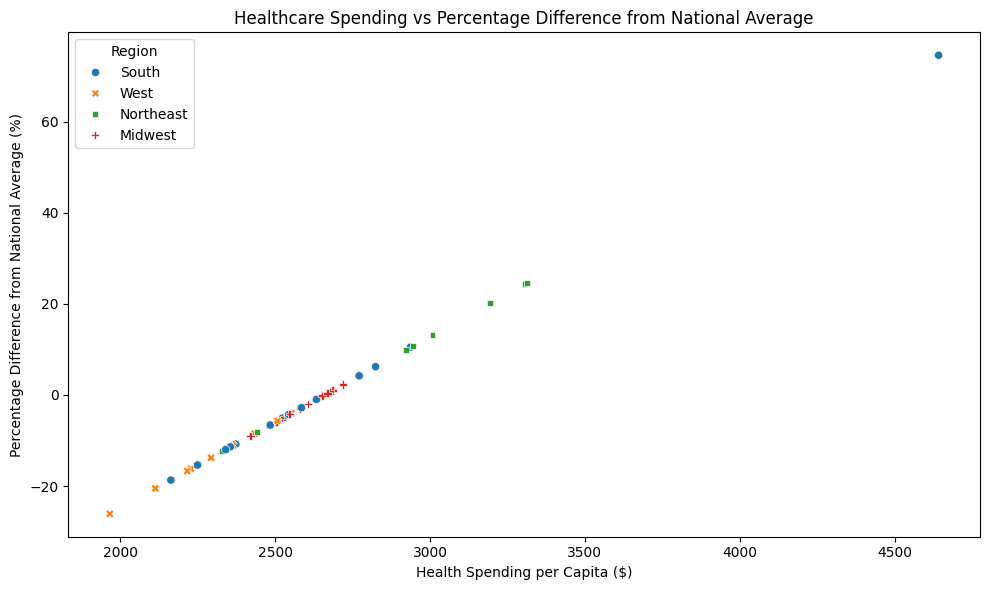

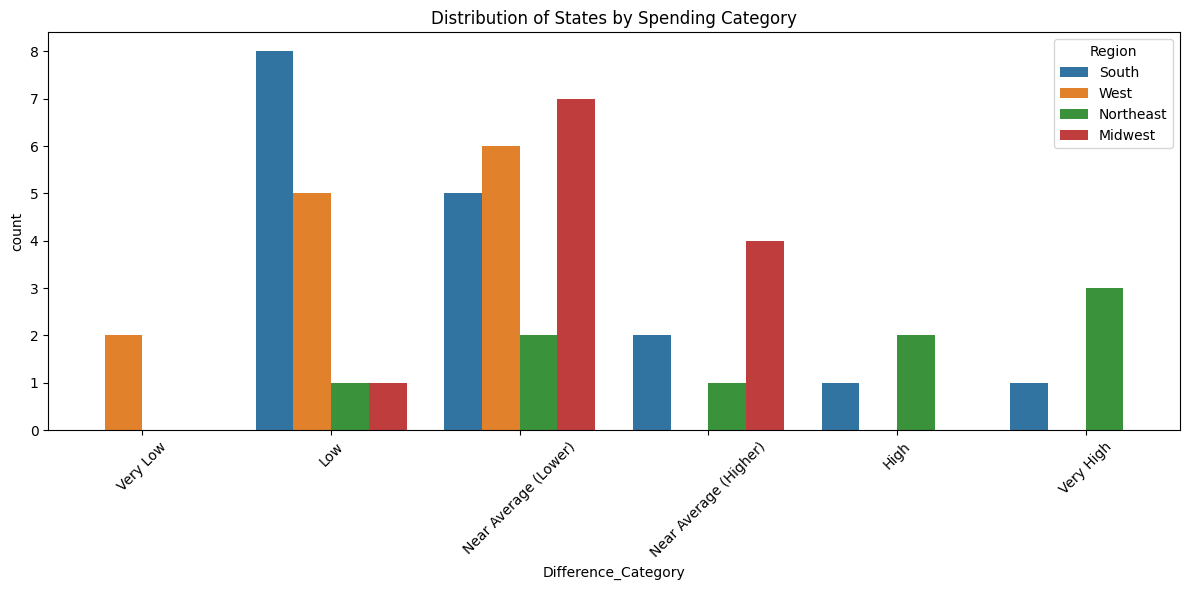


Supplementary Analyses:

Detailed Regional Statistics:


Health Spending per Capita                                        \
                               Count     Mean  Median     Std     CV  Skew   
Region                                                                       
Midwest                           12  2578.58  2593.0  113.00   4.38 -0.76   
Northeast                          9  2888.22  2944.0  371.03  12.85 -0.40   
South                             17  2609.65  2484.0  566.25  21.70  3.19   
West                              13  2364.31  2364.0  199.22   8.43 -0.47   

                  
            Kurt  
Region            
Midwest    -0.15  
Northeast  -1.39  
South      11.55  
West       -0.28


Quartile Analysis by Region:

Northeast Region:
Q1: $2,538.00
Q2 (Median): $2,944.00
Q3: $3,193.00
IQR: $655.00

Midwest Region:
Q1: $2,523.75
Q2 (Median): $2,593.00
Q3: $2,671.00
IQR: $147.25

South Region:
Q1: $2,340.00
Q2 (Median): $2,484.00
Q3: $2,633.00
IQR: $293.00

West Region:
Q1: $2,228.00
Q2 (Median): $2,364.00
Q3: $2,507.00
IQR: $279.00

Regional Mean Distance Matrix:


,Northeast,Midwest,South,West
Northeast,0.0,309.638889,278.575163,523.91453
Midwest,309.638889,0.0,31.063725,214.275641
South,278.575163,31.063725,0.0,245.339367
West,523.91453,214.275641,245.339367,0.0


In [10]:
# Section 10: Appendix
print("\n=== Appendix ===")

# 10.1 Data Preparation Details
print("\nData Preparation Details:")
print("=======================")
# Document the data loading process
print("Data Loading Process:")
print("1. Source: Kaiser Family Foundation (KFF) Healthcare Spending per Capita (1991)")
print("2. Initial columns:", df.columns.tolist())
print("3. Records processed:", len(df))
print("\nData Cleaning Steps:")
print("- Converting spending values to numeric format")
print("- Adding region classifications")
print("- Separating state-level data from US average")

# Display data info
print("\nDataset Information:")
print(state_data.info())

# Check for missing values
print("\nMissing Value Analysis:")
print(state_data.isnull().sum())

# 10.2 Methodological Notes
print("\nMethodological Notes:")
print("===================")
print("Statistical Methods Applied:")
print("1. Descriptive Statistics")
print(" - Measures of central tendency")
print(" - Variability metrics")
print(" - Distribution characteristics")
print("\n2. Inferential Statistics")
print(" - ANOVA testing")
print(" - Tukey's HSD post-hoc analysis")
print(" - T-tests against national average")
print("\n3. Distribution Analysis")
print(" - Normality testing")
print(" - Outlier detection using IQR")
print("\n4. Visualization Techniques")
print(" - Box plots and violin plots")
print(" - Histograms with KDE")
print(" - Bar charts and rankings")

# 10.3 Additional Visualizations
# Correlation matrix (if additional variables were available)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=state_data,
                x='Health Spending per Capita',
                y='Percent_Difference',
                hue='Region',
                style='Region')
plt.title('Healthcare Spending vs Percentage Difference from National Average')
plt.xlabel('Health Spending per Capita ($)')
plt.ylabel('Percentage Difference from National Average (%)')
plt.tight_layout()
plt.show()

# Distribution by spending category
plt.figure(figsize=(12, 6))
sns.countplot(data=state_data, x='Difference_Category', hue='Region')
plt.title('Distribution of States by Spending Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10.4 Supplementary Analyses
print("\nSupplementary Analyses:")
print("=====================")

# Additional regional statistics
print("\nDetailed Regional Statistics:")
supplementary_stats = state_data.groupby('Region').agg({
    'Health Spending per Capita': [
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Median', 'median'),
        ('Std', 'std'),
        ('CV', lambda x: x.std() / x.mean() * 100),
        ('Skew', 'skew'),
        ('Kurt', lambda x: x.kurt())  # Changed from 'kurtosis' to lambda x: x.kurt()
    ]
}).round(2)
display(supplementary_stats)

# Quartile analysis
print("\nQuartile Analysis by Region:")
for region in ['Northeast', 'Midwest', 'South', 'West']:
    region_data = state_data[state_data['Region'] == region]['Health Spending per Capita']
    q1, q2, q3 = region_data.quantile([0.25, 0.5, 0.75])
    print(f"\n{region} Region:")
    print(f"Q1: ${q1:,.2f}")
    print(f"Q2 (Median): ${q2:,.2f}")
    print(f"Q3: ${q3:,.2f}")
    print(f"IQR: ${q3-q1:,.2f}")

# Distance matrix between regional means
print("\nRegional Mean Distance Matrix:")
regional_means = state_data.groupby('Region')['Health Spending per Capita'].mean()
regions_list = ['Northeast', 'Midwest', 'South', 'West']
distance_matrix = pd.DataFrame(index=regions_list, columns=regions_list)
for r1 in regions_list:
    for r2 in regions_list:
        distance_matrix.loc[r1, r2] = abs(regional_means[r1] - regional_means[r2])
display(distance_matrix.round(2))